# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from pathlib import Path
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
data = Path('D:/data/summer2winter-yosemite_data/summer2winter_yosemite')
def get_data_loader(image_type, image_dir=data, 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = image_dir
    train_path = image_path/image_type
    test_path = image_path / f'test_{image_type}'

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

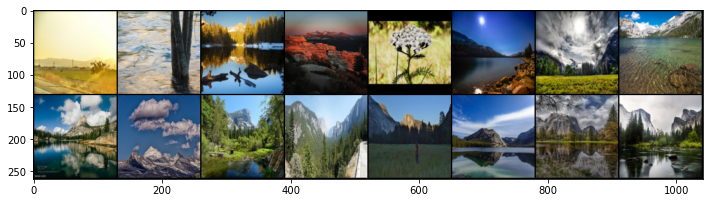

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

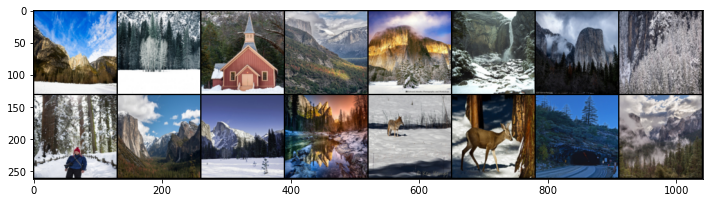

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9961)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.9922)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.N = 4
        self.conv_dim = conv_dim = int(conv_dim)
        for i in range(self.N):
            batch_norm = True
            if i == 0:
                in_ = 3
                out = conv_dim
                batch_norm = False
            else:
                out = conv_dim * 2**(i)
                in_ = conv_dim * 2**(i-1)
            setattr(self, f'conv{i+1}', conv(in_, out, 4, batch_norm=batch_norm))
        self.conv5 = conv(out, 1, 4, padding=1, batch_norm=False)
        
    def forward(self, x):
        # define feedforward behavior
        for i in range(self.N):
            x = F.relu(getattr(self, f'conv{i+1}')(x))
        x = self.conv5(x)
        return x
    
    
def test_discriminator():
    myDisc = Discriminator()
    assert myDisc.conv1[0].out_channels == myDisc.conv2[0].in_channels
    assert myDisc.conv2[0].out_channels == myDisc.conv3[0].in_channels
    
test_discriminator()

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [4]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        conv_dim = int(conv_dim)
        for i in range(2):
            setattr(self, f'res{i+1}', conv(conv_dim, conv_dim, 3, 
                                            stride=1, padding=1, batch_norm=True))
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out = F.relu(self.res1(x))
        out = self.res2(x)
        x = F.relu(out + x)
        return x

    
def test_residualblock():
    myRB = ResidualBlock(20)
    assert myRB.res1[0].in_channels == myRB.res2[0].out_channels

    
test_residualblock()

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [5]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [7]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        # Encoder
        self.N = 3
        self.conv_dim = conv_dim = int(conv_dim)
        self.N_RES = n_res_blocks
        
        for i in range(self.N):
            if i == 0:
                conv_in_ = 3
                conv_out = conv_dim
            else:
                conv_out = conv_dim * 2**i
                conv_in_ = conv_dim * 2**(i-1)
            setattr(self, f'conv{i+1}', conv(conv_in_, conv_out, 4,
                                             batch_norm=True))
        self.conv_depth = conv_out
            

        # 2. Define the resnet part of the generator
        for i in range(self.N_RES):
            setattr(self, f'resnet{i+1}', ResidualBlock(self.conv_depth))
            
        # 3. Define the decoder part of the generator
        for i, j in enumerate(reversed(range(self.N))):  # now go backwards!
            if j == 0:
                deconv_out = 3
                deconv_in_ = conv_dim
                batch_norm = False
            else:
                deconv_in_ = conv_dim * 2**j
                deconv_out = conv_dim * 2**(j-1)
                batch_norm = True
            setattr(self, f'deconv{i+1}', deconv(deconv_in_, deconv_out, 4,
                                                 batch_norm=batch_norm))
        

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        for i in range(self.N):
            x = F.relu(getattr(self, f'conv{i+1}')(x))
            
        for i in range(self.N_RES):
            x = getattr(self, f'resnet{i+1}')(x)
            
        for i in range(self.N-1):
            x = F.relu(getattr(self, f'deconv{i+1}')(x))
        x = F.tanh(getattr(self, f'deconv{self.N}')(x))

        return x
    
def test_cyclegenerator():
    myCG = CycleGenerator()
    assert myCG.conv1[0].in_channels == myCG.deconv3[0].out_channels
    
test_cyclegenerator() #FIXME

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet1): ResidualBlock(
    (res1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (res2): Sequential(
      (0):

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out)**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight * reconstr_loss


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [20]:
# import save code
from helpers import save_samples, checkpoint

In [27]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================
        d_x_optimizer.zero_grad()
        ##   First: D_X, real and fake loss components   ##

        # 1. Compute the discriminator losses on real images
        d_x_real = D_X(images_X)
        d_x_real_loss = real_mse_loss(d_x_real)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        
        fake_x_images = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        d_x_fake = D_X(fake_x_images)
        d_x_fake_loss = fake_mse_loss(d_x_fake)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = d_x_real_loss + d_x_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        
        d_y_real = D_Y(images_Y)
        d_y_real_loss = real_mse_loss(d_y_real)
        
        fake_y_images = G_XtoY(images_X)
        
        d_y_fake = D_Y(fake_y_images)
        d_y_fake_loss = fake_mse_loss(d_y_fake)
        
        d_y_loss = d_y_real_loss + d_y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()
        

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================
        g_optimizer.zero_grad()
        ##    First: generate fake X images and reconstructed Y images    ##

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_x_images = G_YtoX(images_Y)
        recon_y_images = G_XtoY(fake_x_images)
        
        # 2. Compute the generator loss based on domain X
        
        d_x_fake = D_X(fake_x_images)
        g_x_loss = real_mse_loss(d_x_fake)
        
        # 3. Create a reconstructed y
        # DONE
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        cyc_y_loss = cycle_consistency_loss(images_Y, recon_y_images, 10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        fake_y_images = G_XtoY(images_X)
        recon_x_images = G_YtoX(fake_y_images)

        d_y_fake = D_Y(fake_y_images)
        g_y_loss = real_mse_loss(d_y_fake)
        
        cyc_x_loss = cycle_consistency_loss(images_X, recon_x_images, 10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_x_loss + g_y_loss + cyc_y_loss + cyc_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [29]:
n_epochs = 4000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.4065 | d_Y_loss: 0.1598 | g_total_loss: 6.3939
Epoch [   20/ 4000] | d_X_loss: 0.3007 | d_Y_loss: 0.2077 | g_total_loss: 4.7604
Epoch [   30/ 4000] | d_X_loss: 0.1994 | d_Y_loss: 0.1442 | g_total_loss: 4.4570
Epoch [   40/ 4000] | d_X_loss: 0.4387 | d_Y_loss: 0.1573 | g_total_loss: 4.1575
Epoch [   50/ 4000] | d_X_loss: 0.2352 | d_Y_loss: 0.2234 | g_total_loss: 5.3477
Epoch [   60/ 4000] | d_X_loss: 0.1957 | d_Y_loss: 0.1733 | g_total_loss: 4.4947
Epoch [   70/ 4000] | d_X_loss: 0.2046 | d_Y_loss: 0.1902 | g_total_loss: 5.3754
Epoch [   80/ 4000] | d_X_loss: 0.1532 | d_Y_loss: 0.1613 | g_total_loss: 4.1168
Epoch [   90/ 4000] | d_X_loss: 0.1765 | d_Y_loss: 0.1394 | g_total_loss: 4.0910


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.1923 | d_Y_loss: 0.1372 | g_total_loss: 4.3438


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-X-Y.png
Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.2006 | d_Y_loss: 0.1409 | g_total_loss: 4.7364
Epoch [  120/ 4000] | d_X_loss: 0.2670 | d_Y_loss: 0.1367 | g_total_loss: 4.4702
Epoch [  130/ 4000] | d_X_loss: 0.1558 | d_Y_loss: 0.1594 | g_total_loss: 4.8928
Epoch [  140/ 4000] | d_X_loss: 0.1940 | d_Y_loss: 0.1235 | g_total_loss: 4.8911
Epoch [  150/ 4000] | d_X_loss: 0.1384 | d_Y_loss: 0.0963 | g_total_loss: 4.2392
Epoch [  160/ 4000] | d_X_loss: 0.1678 | d_Y_loss: 0.1168 | g_total_loss: 4.9660
Epoch [  170/ 4000] | d_X_loss: 0.1754 | d_Y_loss: 0.1594 | g_total_loss: 4.7385
Epoch [  180/ 4000] | d_X_loss: 0.1871 | d_Y_loss: 0.1592 | g_total_loss: 5.4468
Epoch [  190/ 4000] | d_X_loss: 0.1032 | d_Y_loss: 0.1455 | g_total_loss: 4.8498


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.1901 | d_Y_loss: 0.1060 | g_total_loss: 4.8407


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-X-Y.png
Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.2540 | d_Y_loss: 0.1284 | g_total_loss: 5.3238
Epoch [  220/ 4000] | d_X_loss: 0.1465 | d_Y_loss: 0.1147 | g_total_loss: 4.1243
Epoch [  230/ 4000] | d_X_loss: 0.2075 | d_Y_loss: 0.1866 | g_total_loss: 4.0109
Epoch [  240/ 4000] | d_X_loss: 0.1656 | d_Y_loss: 0.1132 | g_total_loss: 4.5050
Epoch [  250/ 4000] | d_X_loss: 0.1295 | d_Y_loss: 0.1448 | g_total_loss: 4.7731
Epoch [  260/ 4000] | d_X_loss: 0.1151 | d_Y_loss: 0.1026 | g_total_loss: 4.7886
Epoch [  270/ 4000] | d_X_loss: 0.1641 | d_Y_loss: 0.1755 | g_total_loss: 5.7694
Epoch [  280/ 4000] | d_X_loss: 0.1638 | d_Y_loss: 0.1166 | g_total_loss: 5.4546
Epoch [  290/ 4000] | d_X_loss: 0.2218 | d_Y_loss: 0.1209 | g_total_loss: 4.9987


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 4000] | d_X_loss: 0.1647 | d_Y_loss: 0.1497 | g_total_loss: 4.2823


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-X-Y.png
Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.1537 | d_Y_loss: 0.1610 | g_total_loss: 4.5771
Epoch [  320/ 4000] | d_X_loss: 0.1440 | d_Y_loss: 0.1083 | g_total_loss: 5.1344
Epoch [  330/ 4000] | d_X_loss: 0.2480 | d_Y_loss: 0.1354 | g_total_loss: 4.4517
Epoch [  340/ 4000] | d_X_loss: 0.1396 | d_Y_loss: 0.1458 | g_total_loss: 4.2240
Epoch [  350/ 4000] | d_X_loss: 0.1863 | d_Y_loss: 0.1185 | g_total_loss: 5.2296
Epoch [  360/ 4000] | d_X_loss: 0.1779 | d_Y_loss: 0.1164 | g_total_loss: 4.9600
Epoch [  370/ 4000] | d_X_loss: 0.1506 | d_Y_loss: 0.1192 | g_total_loss: 5.4848
Epoch [  380/ 4000] | d_X_loss: 0.1242 | d_Y_loss: 0.1257 | g_total_loss: 4.7139
Epoch [  390/ 4000] | d_X_loss: 0.1154 | d_Y_loss: 0.1128 | g_total_loss: 4.7233


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 4000] | d_X_loss: 0.2289 | d_Y_loss: 0.2005 | g_total_loss: 4.7617


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-X-Y.png
Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.1563 | d_Y_loss: 0.1014 | g_total_loss: 4.9106
Epoch [  420/ 4000] | d_X_loss: 0.1365 | d_Y_loss: 0.1774 | g_total_loss: 5.1924
Epoch [  430/ 4000] | d_X_loss: 0.1333 | d_Y_loss: 0.1698 | g_total_loss: 4.7180
Epoch [  440/ 4000] | d_X_loss: 0.1327 | d_Y_loss: 0.1179 | g_total_loss: 4.6734
Epoch [  450/ 4000] | d_X_loss: 0.1830 | d_Y_loss: 0.1219 | g_total_loss: 4.1783
Epoch [  460/ 4000] | d_X_loss: 0.1607 | d_Y_loss: 0.1385 | g_total_loss: 4.1338
Epoch [  470/ 4000] | d_X_loss: 0.1318 | d_Y_loss: 0.1195 | g_total_loss: 4.8332
Epoch [  480/ 4000] | d_X_loss: 0.2156 | d_Y_loss: 0.1137 | g_total_loss: 4.2602
Epoch [  490/ 4000] | d_X_loss: 0.2282 | d_Y_loss: 0.1538 | g_total_loss: 4.8500


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 4000] | d_X_loss: 0.1182 | d_Y_loss: 0.1541 | g_total_loss: 4.7288


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-X-Y.png
Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.1503 | d_Y_loss: 0.1356 | g_total_loss: 4.6925
Epoch [  520/ 4000] | d_X_loss: 0.1367 | d_Y_loss: 0.1303 | g_total_loss: 4.0653
Epoch [  530/ 4000] | d_X_loss: 0.1898 | d_Y_loss: 0.1535 | g_total_loss: 4.3942
Epoch [  540/ 4000] | d_X_loss: 0.1991 | d_Y_loss: 0.1177 | g_total_loss: 4.5972
Epoch [  550/ 4000] | d_X_loss: 0.1403 | d_Y_loss: 0.0869 | g_total_loss: 4.2335
Epoch [  560/ 4000] | d_X_loss: 0.1148 | d_Y_loss: 0.1038 | g_total_loss: 4.7477
Epoch [  570/ 4000] | d_X_loss: 0.1176 | d_Y_loss: 0.1036 | g_total_loss: 5.1168
Epoch [  580/ 4000] | d_X_loss: 0.1879 | d_Y_loss: 0.2109 | g_total_loss: 3.7079
Epoch [  590/ 4000] | d_X_loss: 0.1028 | d_Y_loss: 0.1087 | g_total_loss: 4.5377


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 4000] | d_X_loss: 0.4302 | d_Y_loss: 0.1218 | g_total_loss: 5.3852


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-X-Y.png
Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.2031 | d_Y_loss: 0.1269 | g_total_loss: 5.8788
Epoch [  620/ 4000] | d_X_loss: 0.1520 | d_Y_loss: 0.1009 | g_total_loss: 4.5996
Epoch [  630/ 4000] | d_X_loss: 0.1411 | d_Y_loss: 0.1117 | g_total_loss: 4.5582
Epoch [  640/ 4000] | d_X_loss: 0.1449 | d_Y_loss: 0.1188 | g_total_loss: 4.2603
Epoch [  650/ 4000] | d_X_loss: 0.1137 | d_Y_loss: 0.0938 | g_total_loss: 5.0868
Epoch [  660/ 4000] | d_X_loss: 0.1265 | d_Y_loss: 0.1613 | g_total_loss: 4.6990
Epoch [  670/ 4000] | d_X_loss: 0.1348 | d_Y_loss: 0.1481 | g_total_loss: 6.2503
Epoch [  680/ 4000] | d_X_loss: 0.1488 | d_Y_loss: 0.0851 | g_total_loss: 4.6441
Epoch [  690/ 4000] | d_X_loss: 0.1457 | d_Y_loss: 0.1368 | g_total_loss: 4.4728


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 4000] | d_X_loss: 0.1175 | d_Y_loss: 0.1801 | g_total_loss: 4.4885


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-X-Y.png
Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.1109 | d_Y_loss: 0.1289 | g_total_loss: 4.3375
Epoch [  720/ 4000] | d_X_loss: 0.2043 | d_Y_loss: 0.0940 | g_total_loss: 4.1938
Epoch [  730/ 4000] | d_X_loss: 0.1812 | d_Y_loss: 0.0830 | g_total_loss: 5.6027
Epoch [  740/ 4000] | d_X_loss: 0.1296 | d_Y_loss: 0.1696 | g_total_loss: 4.3765
Epoch [  750/ 4000] | d_X_loss: 0.1124 | d_Y_loss: 0.1608 | g_total_loss: 4.6394
Epoch [  760/ 4000] | d_X_loss: 0.1364 | d_Y_loss: 0.1219 | g_total_loss: 4.4462
Epoch [  770/ 4000] | d_X_loss: 0.0869 | d_Y_loss: 0.0988 | g_total_loss: 5.1674
Epoch [  780/ 4000] | d_X_loss: 0.1066 | d_Y_loss: 0.1353 | g_total_loss: 4.4746
Epoch [  790/ 4000] | d_X_loss: 0.1031 | d_Y_loss: 0.0874 | g_total_loss: 4.5142


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 4000] | d_X_loss: 0.2089 | d_Y_loss: 0.0958 | g_total_loss: 5.3487


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-X-Y.png
Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.1209 | d_Y_loss: 0.1996 | g_total_loss: 4.0180
Epoch [  820/ 4000] | d_X_loss: 0.1392 | d_Y_loss: 0.0986 | g_total_loss: 5.2640
Epoch [  830/ 4000] | d_X_loss: 0.1350 | d_Y_loss: 0.1140 | g_total_loss: 4.9988
Epoch [  840/ 4000] | d_X_loss: 0.1323 | d_Y_loss: 0.0867 | g_total_loss: 4.0891
Epoch [  850/ 4000] | d_X_loss: 0.1463 | d_Y_loss: 0.0978 | g_total_loss: 4.0650
Epoch [  860/ 4000] | d_X_loss: 0.0929 | d_Y_loss: 0.1624 | g_total_loss: 4.4153
Epoch [  870/ 4000] | d_X_loss: 0.1094 | d_Y_loss: 0.0811 | g_total_loss: 4.2968
Epoch [  880/ 4000] | d_X_loss: 0.1308 | d_Y_loss: 0.1428 | g_total_loss: 4.5360
Epoch [  890/ 4000] | d_X_loss: 0.1558 | d_Y_loss: 0.0769 | g_total_loss: 5.0633


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.1141 | d_Y_loss: 0.0729 | g_total_loss: 4.6616


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-X-Y.png
Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.1389 | d_Y_loss: 0.0705 | g_total_loss: 5.0932
Epoch [  920/ 4000] | d_X_loss: 0.1175 | d_Y_loss: 0.1038 | g_total_loss: 5.3998
Epoch [  930/ 4000] | d_X_loss: 0.1098 | d_Y_loss: 0.0821 | g_total_loss: 3.9346
Epoch [  940/ 4000] | d_X_loss: 0.0988 | d_Y_loss: 0.0945 | g_total_loss: 4.8069
Epoch [  950/ 4000] | d_X_loss: 0.1476 | d_Y_loss: 0.3490 | g_total_loss: 4.8768
Epoch [  960/ 4000] | d_X_loss: 0.2004 | d_Y_loss: 0.0799 | g_total_loss: 4.0798
Epoch [  970/ 4000] | d_X_loss: 0.1909 | d_Y_loss: 0.1012 | g_total_loss: 4.1166
Epoch [  980/ 4000] | d_X_loss: 0.1441 | d_Y_loss: 0.1561 | g_total_loss: 3.8648
Epoch [  990/ 4000] | d_X_loss: 0.1589 | d_Y_loss: 0.1133 | g_total_loss: 4.5298


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.0822 | d_Y_loss: 0.1344 | g_total_loss: 5.2300


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-X-Y.png
Saved samples_cyclegan\sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.1219 | d_Y_loss: 0.1170 | g_total_loss: 4.5397
Epoch [ 1020/ 4000] | d_X_loss: 0.2919 | d_Y_loss: 0.0803 | g_total_loss: 3.4965
Epoch [ 1030/ 4000] | d_X_loss: 0.1052 | d_Y_loss: 0.0836 | g_total_loss: 4.3132
Epoch [ 1040/ 4000] | d_X_loss: 0.1336 | d_Y_loss: 0.1405 | g_total_loss: 4.3655
Epoch [ 1050/ 4000] | d_X_loss: 0.1086 | d_Y_loss: 0.1360 | g_total_loss: 4.8749
Epoch [ 1060/ 4000] | d_X_loss: 0.0922 | d_Y_loss: 0.0935 | g_total_loss: 4.3959
Epoch [ 1070/ 4000] | d_X_loss: 0.1036 | d_Y_loss: 0.1092 | g_total_loss: 4.3440
Epoch [ 1080/ 4000] | d_X_loss: 0.1316 | d_Y_loss: 0.0718 | g_total_loss: 3.8876
Epoch [ 1090/ 4000] | d_X_loss: 0.2211 | d_Y_loss: 0.0915 | g_total_loss: 5.6851


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.1460 | d_Y_loss: 0.1210 | g_total_loss: 4.8610


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-X-Y.png
Saved samples_cyclegan\sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.1261 | d_Y_loss: 0.0954 | g_total_loss: 5.0693
Epoch [ 1120/ 4000] | d_X_loss: 0.1174 | d_Y_loss: 0.1002 | g_total_loss: 5.4546
Epoch [ 1130/ 4000] | d_X_loss: 0.1765 | d_Y_loss: 0.0870 | g_total_loss: 4.4721
Epoch [ 1140/ 4000] | d_X_loss: 0.1112 | d_Y_loss: 0.0800 | g_total_loss: 4.9845
Epoch [ 1150/ 4000] | d_X_loss: 0.1240 | d_Y_loss: 0.0622 | g_total_loss: 4.1893
Epoch [ 1160/ 4000] | d_X_loss: 0.1183 | d_Y_loss: 0.1882 | g_total_loss: 4.3268
Epoch [ 1170/ 4000] | d_X_loss: 0.1038 | d_Y_loss: 0.1166 | g_total_loss: 4.9113
Epoch [ 1180/ 4000] | d_X_loss: 0.0961 | d_Y_loss: 0.0718 | g_total_loss: 4.9312
Epoch [ 1190/ 4000] | d_X_loss: 0.1326 | d_Y_loss: 0.0747 | g_total_loss: 5.6933


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.1020 | d_Y_loss: 0.0665 | g_total_loss: 4.5785


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-X-Y.png
Saved samples_cyclegan\sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.1255 | d_Y_loss: 0.0929 | g_total_loss: 4.3519
Epoch [ 1220/ 4000] | d_X_loss: 0.2006 | d_Y_loss: 0.2180 | g_total_loss: 6.8675
Epoch [ 1230/ 4000] | d_X_loss: 0.1415 | d_Y_loss: 0.0978 | g_total_loss: 4.8079
Epoch [ 1240/ 4000] | d_X_loss: 0.1590 | d_Y_loss: 0.0772 | g_total_loss: 4.4424
Epoch [ 1250/ 4000] | d_X_loss: 0.0977 | d_Y_loss: 0.0657 | g_total_loss: 4.6023
Epoch [ 1260/ 4000] | d_X_loss: 0.0919 | d_Y_loss: 0.0891 | g_total_loss: 3.9380
Epoch [ 1270/ 4000] | d_X_loss: 0.1048 | d_Y_loss: 0.1010 | g_total_loss: 4.0721
Epoch [ 1280/ 4000] | d_X_loss: 0.0813 | d_Y_loss: 0.0681 | g_total_loss: 6.5494
Epoch [ 1290/ 4000] | d_X_loss: 0.2275 | d_Y_loss: 0.0901 | g_total_loss: 4.0177


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 4000] | d_X_loss: 0.1150 | d_Y_loss: 0.0972 | g_total_loss: 5.3352


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-X-Y.png
Saved samples_cyclegan\sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.1530 | d_Y_loss: 0.0803 | g_total_loss: 5.1730
Epoch [ 1320/ 4000] | d_X_loss: 0.1214 | d_Y_loss: 0.1206 | g_total_loss: 4.9640
Epoch [ 1330/ 4000] | d_X_loss: 0.1052 | d_Y_loss: 0.2252 | g_total_loss: 3.8422
Epoch [ 1340/ 4000] | d_X_loss: 0.1069 | d_Y_loss: 0.1415 | g_total_loss: 4.9673
Epoch [ 1350/ 4000] | d_X_loss: 0.1681 | d_Y_loss: 0.1427 | g_total_loss: 3.7450
Epoch [ 1360/ 4000] | d_X_loss: 0.1286 | d_Y_loss: 0.0626 | g_total_loss: 3.9304
Epoch [ 1370/ 4000] | d_X_loss: 0.1149 | d_Y_loss: 0.1124 | g_total_loss: 4.7383
Epoch [ 1380/ 4000] | d_X_loss: 0.0724 | d_Y_loss: 0.0897 | g_total_loss: 4.7034
Epoch [ 1390/ 4000] | d_X_loss: 0.1302 | d_Y_loss: 0.0968 | g_total_loss: 4.4888


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.1181 | d_Y_loss: 0.0823 | g_total_loss: 5.1137


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-X-Y.png
Saved samples_cyclegan\sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.1102 | d_Y_loss: 0.1073 | g_total_loss: 4.4288
Epoch [ 1420/ 4000] | d_X_loss: 0.0940 | d_Y_loss: 0.1037 | g_total_loss: 4.9779
Epoch [ 1430/ 4000] | d_X_loss: 0.0710 | d_Y_loss: 0.1275 | g_total_loss: 3.9871
Epoch [ 1440/ 4000] | d_X_loss: 0.1406 | d_Y_loss: 0.1060 | g_total_loss: 4.7820
Epoch [ 1450/ 4000] | d_X_loss: 0.0812 | d_Y_loss: 0.1012 | g_total_loss: 4.3905
Epoch [ 1460/ 4000] | d_X_loss: 0.0937 | d_Y_loss: 0.1267 | g_total_loss: 4.2708
Epoch [ 1470/ 4000] | d_X_loss: 0.0816 | d_Y_loss: 0.0831 | g_total_loss: 4.7166
Epoch [ 1480/ 4000] | d_X_loss: 0.0709 | d_Y_loss: 0.0873 | g_total_loss: 4.9544
Epoch [ 1490/ 4000] | d_X_loss: 0.1380 | d_Y_loss: 0.0666 | g_total_loss: 3.9813


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 4000] | d_X_loss: 0.0948 | d_Y_loss: 0.0767 | g_total_loss: 4.5677


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-X-Y.png
Saved samples_cyclegan\sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.1102 | d_Y_loss: 0.1120 | g_total_loss: 4.6009
Epoch [ 1520/ 4000] | d_X_loss: 0.1174 | d_Y_loss: 0.0854 | g_total_loss: 4.8644
Epoch [ 1530/ 4000] | d_X_loss: 0.1542 | d_Y_loss: 0.1036 | g_total_loss: 4.3159
Epoch [ 1540/ 4000] | d_X_loss: 0.1036 | d_Y_loss: 0.1118 | g_total_loss: 4.6885
Epoch [ 1550/ 4000] | d_X_loss: 0.0861 | d_Y_loss: 0.0932 | g_total_loss: 4.8917
Epoch [ 1560/ 4000] | d_X_loss: 0.0742 | d_Y_loss: 0.0925 | g_total_loss: 4.2886
Epoch [ 1570/ 4000] | d_X_loss: 0.1393 | d_Y_loss: 0.0833 | g_total_loss: 3.8580
Epoch [ 1580/ 4000] | d_X_loss: 0.1380 | d_Y_loss: 0.1070 | g_total_loss: 5.5570
Epoch [ 1590/ 4000] | d_X_loss: 0.1330 | d_Y_loss: 0.0810 | g_total_loss: 5.2644


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 4000] | d_X_loss: 0.0875 | d_Y_loss: 0.1701 | g_total_loss: 3.9793


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001600-X-Y.png
Saved samples_cyclegan\sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.0608 | d_Y_loss: 0.0832 | g_total_loss: 4.2958
Epoch [ 1620/ 4000] | d_X_loss: 0.1777 | d_Y_loss: 0.0650 | g_total_loss: 4.1996
Epoch [ 1630/ 4000] | d_X_loss: 0.1083 | d_Y_loss: 0.0732 | g_total_loss: 4.4244
Epoch [ 1640/ 4000] | d_X_loss: 0.1187 | d_Y_loss: 0.0718 | g_total_loss: 5.0574
Epoch [ 1650/ 4000] | d_X_loss: 0.0822 | d_Y_loss: 0.0894 | g_total_loss: 4.4935
Epoch [ 1660/ 4000] | d_X_loss: 0.0850 | d_Y_loss: 0.1078 | g_total_loss: 4.8003
Epoch [ 1670/ 4000] | d_X_loss: 0.1340 | d_Y_loss: 0.0934 | g_total_loss: 4.6388
Epoch [ 1680/ 4000] | d_X_loss: 0.1764 | d_Y_loss: 0.0755 | g_total_loss: 4.2875
Epoch [ 1690/ 4000] | d_X_loss: 0.1343 | d_Y_loss: 0.0917 | g_total_loss: 5.5054


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 4000] | d_X_loss: 0.1841 | d_Y_loss: 0.0986 | g_total_loss: 5.9263


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001700-X-Y.png
Saved samples_cyclegan\sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.1228 | d_Y_loss: 0.1671 | g_total_loss: 5.0290
Epoch [ 1720/ 4000] | d_X_loss: 0.1554 | d_Y_loss: 0.0846 | g_total_loss: 4.2796
Epoch [ 1730/ 4000] | d_X_loss: 0.0835 | d_Y_loss: 0.1175 | g_total_loss: 4.6602
Epoch [ 1740/ 4000] | d_X_loss: 0.0799 | d_Y_loss: 0.1014 | g_total_loss: 3.9570
Epoch [ 1750/ 4000] | d_X_loss: 0.0999 | d_Y_loss: 0.0716 | g_total_loss: 4.4438
Epoch [ 1760/ 4000] | d_X_loss: 0.1082 | d_Y_loss: 0.1069 | g_total_loss: 5.4821
Epoch [ 1770/ 4000] | d_X_loss: 0.0711 | d_Y_loss: 0.0709 | g_total_loss: 4.5983
Epoch [ 1780/ 4000] | d_X_loss: 0.0712 | d_Y_loss: 0.1120 | g_total_loss: 4.6774
Epoch [ 1790/ 4000] | d_X_loss: 0.0830 | d_Y_loss: 0.0907 | g_total_loss: 4.3520


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.0879 | d_Y_loss: 0.0642 | g_total_loss: 4.4326


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001800-X-Y.png
Saved samples_cyclegan\sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.0912 | d_Y_loss: 0.0761 | g_total_loss: 4.5448
Epoch [ 1820/ 4000] | d_X_loss: 0.0893 | d_Y_loss: 0.0770 | g_total_loss: 4.4279
Epoch [ 1830/ 4000] | d_X_loss: 0.4788 | d_Y_loss: 0.5667 | g_total_loss: 8.3619
Epoch [ 1840/ 4000] | d_X_loss: 0.1227 | d_Y_loss: 0.1934 | g_total_loss: 4.4128
Epoch [ 1850/ 4000] | d_X_loss: 0.1229 | d_Y_loss: 0.1332 | g_total_loss: 4.7797
Epoch [ 1860/ 4000] | d_X_loss: 0.0912 | d_Y_loss: 0.0885 | g_total_loss: 4.5121
Epoch [ 1870/ 4000] | d_X_loss: 0.0680 | d_Y_loss: 0.0778 | g_total_loss: 4.1498
Epoch [ 1880/ 4000] | d_X_loss: 0.0768 | d_Y_loss: 0.1249 | g_total_loss: 4.5701
Epoch [ 1890/ 4000] | d_X_loss: 0.0600 | d_Y_loss: 0.1584 | g_total_loss: 8.1677


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 4000] | d_X_loss: 0.0840 | d_Y_loss: 0.0949 | g_total_loss: 4.1743


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001900-X-Y.png
Saved samples_cyclegan\sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.3887 | d_Y_loss: 0.0878 | g_total_loss: 5.3925
Epoch [ 1920/ 4000] | d_X_loss: 0.1063 | d_Y_loss: 0.0694 | g_total_loss: 4.3659
Epoch [ 1930/ 4000] | d_X_loss: 0.1051 | d_Y_loss: 0.0952 | g_total_loss: 4.7213
Epoch [ 1940/ 4000] | d_X_loss: 0.1354 | d_Y_loss: 0.0866 | g_total_loss: 4.3538
Epoch [ 1950/ 4000] | d_X_loss: 0.1302 | d_Y_loss: 0.1477 | g_total_loss: 5.4051
Epoch [ 1960/ 4000] | d_X_loss: 0.0970 | d_Y_loss: 0.1642 | g_total_loss: 4.2914
Epoch [ 1970/ 4000] | d_X_loss: 0.0690 | d_Y_loss: 0.0761 | g_total_loss: 4.9024
Epoch [ 1980/ 4000] | d_X_loss: 0.0663 | d_Y_loss: 0.1014 | g_total_loss: 4.7942
Epoch [ 1990/ 4000] | d_X_loss: 0.1653 | d_Y_loss: 0.0977 | g_total_loss: 5.1488


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.1260 | d_Y_loss: 0.0617 | g_total_loss: 4.9790


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002000-X-Y.png
Saved samples_cyclegan\sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.1355 | d_Y_loss: 0.0696 | g_total_loss: 3.6071
Epoch [ 2020/ 4000] | d_X_loss: 0.1236 | d_Y_loss: 0.1170 | g_total_loss: 4.4609
Epoch [ 2030/ 4000] | d_X_loss: 0.1742 | d_Y_loss: 0.0949 | g_total_loss: 4.0352
Epoch [ 2040/ 4000] | d_X_loss: 0.1220 | d_Y_loss: 0.0861 | g_total_loss: 4.2767
Epoch [ 2050/ 4000] | d_X_loss: 0.1362 | d_Y_loss: 0.0824 | g_total_loss: 5.6588
Epoch [ 2060/ 4000] | d_X_loss: 0.1425 | d_Y_loss: 0.0803 | g_total_loss: 3.9818
Epoch [ 2070/ 4000] | d_X_loss: 0.1308 | d_Y_loss: 0.0860 | g_total_loss: 4.3310
Epoch [ 2080/ 4000] | d_X_loss: 0.0867 | d_Y_loss: 0.0897 | g_total_loss: 4.2573
Epoch [ 2090/ 4000] | d_X_loss: 0.2346 | d_Y_loss: 0.0753 | g_total_loss: 4.0461


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 4000] | d_X_loss: 0.0626 | d_Y_loss: 0.0573 | g_total_loss: 4.0512


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002100-X-Y.png
Saved samples_cyclegan\sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.0850 | d_Y_loss: 0.0579 | g_total_loss: 4.1266
Epoch [ 2120/ 4000] | d_X_loss: 0.0727 | d_Y_loss: 0.0602 | g_total_loss: 4.2873
Epoch [ 2130/ 4000] | d_X_loss: 0.0844 | d_Y_loss: 0.1186 | g_total_loss: 5.0368
Epoch [ 2140/ 4000] | d_X_loss: 0.1094 | d_Y_loss: 0.1358 | g_total_loss: 5.4549
Epoch [ 2150/ 4000] | d_X_loss: 0.0677 | d_Y_loss: 0.0594 | g_total_loss: 4.5174
Epoch [ 2160/ 4000] | d_X_loss: 0.1063 | d_Y_loss: 0.0550 | g_total_loss: 4.4272
Epoch [ 2170/ 4000] | d_X_loss: 0.0848 | d_Y_loss: 0.2356 | g_total_loss: 5.0373
Epoch [ 2180/ 4000] | d_X_loss: 0.1084 | d_Y_loss: 0.0537 | g_total_loss: 5.3292
Epoch [ 2190/ 4000] | d_X_loss: 0.1019 | d_Y_loss: 0.0542 | g_total_loss: 4.5871


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.1625 | d_Y_loss: 0.1096 | g_total_loss: 4.5931


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002200-X-Y.png
Saved samples_cyclegan\sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0962 | d_Y_loss: 0.1397 | g_total_loss: 4.9902
Epoch [ 2220/ 4000] | d_X_loss: 0.0956 | d_Y_loss: 0.0678 | g_total_loss: 4.2163
Epoch [ 2230/ 4000] | d_X_loss: 0.0740 | d_Y_loss: 0.1202 | g_total_loss: 3.9975
Epoch [ 2240/ 4000] | d_X_loss: 0.1606 | d_Y_loss: 0.0642 | g_total_loss: 4.3116
Epoch [ 2250/ 4000] | d_X_loss: 0.0880 | d_Y_loss: 0.0605 | g_total_loss: 4.2146
Epoch [ 2260/ 4000] | d_X_loss: 0.1087 | d_Y_loss: 0.0749 | g_total_loss: 4.3704
Epoch [ 2270/ 4000] | d_X_loss: 0.0821 | d_Y_loss: 0.0612 | g_total_loss: 4.5486
Epoch [ 2280/ 4000] | d_X_loss: 0.1311 | d_Y_loss: 0.0674 | g_total_loss: 3.6042
Epoch [ 2290/ 4000] | d_X_loss: 0.0845 | d_Y_loss: 0.0698 | g_total_loss: 5.2286


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.0927 | d_Y_loss: 0.0597 | g_total_loss: 4.1824


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002300-X-Y.png
Saved samples_cyclegan\sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.1163 | d_Y_loss: 0.0598 | g_total_loss: 3.7719
Epoch [ 2320/ 4000] | d_X_loss: 0.0927 | d_Y_loss: 0.1107 | g_total_loss: 4.8996
Epoch [ 2330/ 4000] | d_X_loss: 0.0729 | d_Y_loss: 0.1887 | g_total_loss: 3.8762
Epoch [ 2340/ 4000] | d_X_loss: 0.0623 | d_Y_loss: 0.0788 | g_total_loss: 4.3425
Epoch [ 2350/ 4000] | d_X_loss: 0.0769 | d_Y_loss: 0.0768 | g_total_loss: 4.3375
Epoch [ 2360/ 4000] | d_X_loss: 0.1253 | d_Y_loss: 0.0488 | g_total_loss: 5.6083
Epoch [ 2370/ 4000] | d_X_loss: 0.1029 | d_Y_loss: 0.0894 | g_total_loss: 4.3543
Epoch [ 2380/ 4000] | d_X_loss: 0.0862 | d_Y_loss: 0.0602 | g_total_loss: 4.5549
Epoch [ 2390/ 4000] | d_X_loss: 0.1201 | d_Y_loss: 0.0571 | g_total_loss: 4.6217


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.0774 | d_Y_loss: 0.0599 | g_total_loss: 4.3728


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002400-X-Y.png
Saved samples_cyclegan\sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0742 | d_Y_loss: 0.0496 | g_total_loss: 4.6291
Epoch [ 2420/ 4000] | d_X_loss: 0.1034 | d_Y_loss: 0.0589 | g_total_loss: 4.3074
Epoch [ 2430/ 4000] | d_X_loss: 0.0729 | d_Y_loss: 0.0521 | g_total_loss: 4.3481
Epoch [ 2440/ 4000] | d_X_loss: 0.2477 | d_Y_loss: 0.1332 | g_total_loss: 7.3031
Epoch [ 2450/ 4000] | d_X_loss: 0.1165 | d_Y_loss: 0.0924 | g_total_loss: 3.9934
Epoch [ 2460/ 4000] | d_X_loss: 0.0863 | d_Y_loss: 0.1298 | g_total_loss: 5.1469
Epoch [ 2470/ 4000] | d_X_loss: 0.0834 | d_Y_loss: 0.3251 | g_total_loss: 4.2552
Epoch [ 2480/ 4000] | d_X_loss: 0.0822 | d_Y_loss: 0.0879 | g_total_loss: 4.3576
Epoch [ 2490/ 4000] | d_X_loss: 0.1411 | d_Y_loss: 0.0901 | g_total_loss: 5.5238


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.1625 | d_Y_loss: 0.1134 | g_total_loss: 11.5294


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002500-X-Y.png
Saved samples_cyclegan\sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.0653 | d_Y_loss: 0.0652 | g_total_loss: 4.2406
Epoch [ 2520/ 4000] | d_X_loss: 0.0632 | d_Y_loss: 0.0784 | g_total_loss: 4.6184
Epoch [ 2530/ 4000] | d_X_loss: 0.0576 | d_Y_loss: 0.0831 | g_total_loss: 5.0871
Epoch [ 2540/ 4000] | d_X_loss: 0.0768 | d_Y_loss: 0.1135 | g_total_loss: 3.7915
Epoch [ 2550/ 4000] | d_X_loss: 0.0607 | d_Y_loss: 0.0686 | g_total_loss: 4.5771
Epoch [ 2560/ 4000] | d_X_loss: 0.0820 | d_Y_loss: 0.0515 | g_total_loss: 4.0186
Epoch [ 2570/ 4000] | d_X_loss: 0.0437 | d_Y_loss: 0.0980 | g_total_loss: 4.9728
Epoch [ 2580/ 4000] | d_X_loss: 0.1744 | d_Y_loss: 0.0621 | g_total_loss: 3.6259
Epoch [ 2590/ 4000] | d_X_loss: 0.0542 | d_Y_loss: 0.0774 | g_total_loss: 5.0331


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.0971 | d_Y_loss: 0.0429 | g_total_loss: 5.1464


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002600-X-Y.png
Saved samples_cyclegan\sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0926 | d_Y_loss: 0.0655 | g_total_loss: 4.6799
Epoch [ 2620/ 4000] | d_X_loss: 0.1163 | d_Y_loss: 0.1432 | g_total_loss: 3.5862
Epoch [ 2630/ 4000] | d_X_loss: 0.0513 | d_Y_loss: 0.0508 | g_total_loss: 4.6284
Epoch [ 2640/ 4000] | d_X_loss: 0.0918 | d_Y_loss: 0.0423 | g_total_loss: 4.4350
Epoch [ 2650/ 4000] | d_X_loss: 0.0785 | d_Y_loss: 0.0755 | g_total_loss: 4.6277
Epoch [ 2660/ 4000] | d_X_loss: 0.1210 | d_Y_loss: 0.0978 | g_total_loss: 5.2214
Epoch [ 2670/ 4000] | d_X_loss: 0.0899 | d_Y_loss: 0.0683 | g_total_loss: 4.4220
Epoch [ 2680/ 4000] | d_X_loss: 0.0713 | d_Y_loss: 0.1348 | g_total_loss: 5.3101
Epoch [ 2690/ 4000] | d_X_loss: 0.1265 | d_Y_loss: 0.1650 | g_total_loss: 4.3834


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.1159 | d_Y_loss: 0.1602 | g_total_loss: 4.3113


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002700-X-Y.png
Saved samples_cyclegan\sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.0719 | d_Y_loss: 0.0971 | g_total_loss: 4.2081
Epoch [ 2720/ 4000] | d_X_loss: 0.0647 | d_Y_loss: 0.0797 | g_total_loss: 4.3582
Epoch [ 2730/ 4000] | d_X_loss: 0.0573 | d_Y_loss: 0.0720 | g_total_loss: 4.3041
Epoch [ 2740/ 4000] | d_X_loss: 0.0645 | d_Y_loss: 0.0524 | g_total_loss: 4.3348
Epoch [ 2750/ 4000] | d_X_loss: 0.1214 | d_Y_loss: 0.1721 | g_total_loss: 5.3360
Epoch [ 2760/ 4000] | d_X_loss: 0.0884 | d_Y_loss: 0.0658 | g_total_loss: 4.4110
Epoch [ 2770/ 4000] | d_X_loss: 0.1878 | d_Y_loss: 0.1157 | g_total_loss: 3.4866
Epoch [ 2780/ 4000] | d_X_loss: 0.1273 | d_Y_loss: 0.0604 | g_total_loss: 3.9663
Epoch [ 2790/ 4000] | d_X_loss: 0.1163 | d_Y_loss: 0.0669 | g_total_loss: 4.5481


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.1434 | d_Y_loss: 0.0623 | g_total_loss: 5.2629


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002800-X-Y.png
Saved samples_cyclegan\sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.0794 | d_Y_loss: 0.0621 | g_total_loss: 4.5160
Epoch [ 2820/ 4000] | d_X_loss: 0.0897 | d_Y_loss: 0.0503 | g_total_loss: 4.8510
Epoch [ 2830/ 4000] | d_X_loss: 0.0802 | d_Y_loss: 0.0495 | g_total_loss: 4.2069
Epoch [ 2840/ 4000] | d_X_loss: 0.1239 | d_Y_loss: 0.0719 | g_total_loss: 4.7377
Epoch [ 2850/ 4000] | d_X_loss: 0.0926 | d_Y_loss: 0.0740 | g_total_loss: 4.0758
Epoch [ 2860/ 4000] | d_X_loss: 0.0702 | d_Y_loss: 0.0639 | g_total_loss: 4.1820
Epoch [ 2870/ 4000] | d_X_loss: 0.0773 | d_Y_loss: 0.1828 | g_total_loss: 3.8540
Epoch [ 2880/ 4000] | d_X_loss: 0.1060 | d_Y_loss: 0.1023 | g_total_loss: 4.9376
Epoch [ 2890/ 4000] | d_X_loss: 0.2702 | d_Y_loss: 0.0867 | g_total_loss: 5.4110


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.0844 | d_Y_loss: 0.1661 | g_total_loss: 3.9676


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002900-X-Y.png
Saved samples_cyclegan\sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.1205 | d_Y_loss: 0.0558 | g_total_loss: 5.0652
Epoch [ 2920/ 4000] | d_X_loss: 0.0747 | d_Y_loss: 0.0762 | g_total_loss: 5.0765
Epoch [ 2930/ 4000] | d_X_loss: 0.0671 | d_Y_loss: 0.0633 | g_total_loss: 4.1312
Epoch [ 2940/ 4000] | d_X_loss: 0.0833 | d_Y_loss: 0.0874 | g_total_loss: 4.0639
Epoch [ 2950/ 4000] | d_X_loss: 0.0559 | d_Y_loss: 0.0576 | g_total_loss: 4.6636
Epoch [ 2960/ 4000] | d_X_loss: 0.0621 | d_Y_loss: 0.1062 | g_total_loss: 4.1253
Epoch [ 2970/ 4000] | d_X_loss: 0.1087 | d_Y_loss: 0.0472 | g_total_loss: 4.4527
Epoch [ 2980/ 4000] | d_X_loss: 0.0930 | d_Y_loss: 0.0616 | g_total_loss: 4.4369
Epoch [ 2990/ 4000] | d_X_loss: 0.4308 | d_Y_loss: 0.1899 | g_total_loss: 2.9880


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.0782 | d_Y_loss: 0.0917 | g_total_loss: 4.3084


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003000-X-Y.png
Saved samples_cyclegan\sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.0945 | d_Y_loss: 0.0702 | g_total_loss: 4.1915
Epoch [ 3020/ 4000] | d_X_loss: 0.0849 | d_Y_loss: 0.2240 | g_total_loss: 3.3659
Epoch [ 3030/ 4000] | d_X_loss: 0.0552 | d_Y_loss: 0.0624 | g_total_loss: 4.6625
Epoch [ 3040/ 4000] | d_X_loss: 0.0694 | d_Y_loss: 0.0645 | g_total_loss: 4.3794
Epoch [ 3050/ 4000] | d_X_loss: 0.1936 | d_Y_loss: 0.0724 | g_total_loss: 6.0250
Epoch [ 3060/ 4000] | d_X_loss: 0.1157 | d_Y_loss: 0.0679 | g_total_loss: 3.9589
Epoch [ 3070/ 4000] | d_X_loss: 0.0802 | d_Y_loss: 0.0730 | g_total_loss: 4.2263
Epoch [ 3080/ 4000] | d_X_loss: 0.2025 | d_Y_loss: 0.0486 | g_total_loss: 4.1798
Epoch [ 3090/ 4000] | d_X_loss: 0.0693 | d_Y_loss: 0.0594 | g_total_loss: 4.1812


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.0868 | d_Y_loss: 0.0710 | g_total_loss: 4.3079


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003100-X-Y.png
Saved samples_cyclegan\sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.0813 | d_Y_loss: 0.0461 | g_total_loss: 3.9229
Epoch [ 3120/ 4000] | d_X_loss: 0.0989 | d_Y_loss: 0.0499 | g_total_loss: 4.9838
Epoch [ 3130/ 4000] | d_X_loss: 0.1504 | d_Y_loss: 0.0633 | g_total_loss: 4.0781
Epoch [ 3140/ 4000] | d_X_loss: 0.1032 | d_Y_loss: 0.1064 | g_total_loss: 5.2604
Epoch [ 3150/ 4000] | d_X_loss: 0.1345 | d_Y_loss: 0.1021 | g_total_loss: 3.8328
Epoch [ 3160/ 4000] | d_X_loss: 0.1305 | d_Y_loss: 0.0896 | g_total_loss: 5.3974
Epoch [ 3170/ 4000] | d_X_loss: 0.0993 | d_Y_loss: 0.0567 | g_total_loss: 3.8564
Epoch [ 3180/ 4000] | d_X_loss: 0.0760 | d_Y_loss: 0.0636 | g_total_loss: 4.1484
Epoch [ 3190/ 4000] | d_X_loss: 0.0709 | d_Y_loss: 0.1564 | g_total_loss: 4.7878


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.0635 | d_Y_loss: 0.1006 | g_total_loss: 4.6641


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003200-X-Y.png
Saved samples_cyclegan\sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.1138 | d_Y_loss: 0.0619 | g_total_loss: 4.7598
Epoch [ 3220/ 4000] | d_X_loss: 0.0657 | d_Y_loss: 0.0620 | g_total_loss: 4.7457
Epoch [ 3230/ 4000] | d_X_loss: 0.0833 | d_Y_loss: 0.0636 | g_total_loss: 4.7884
Epoch [ 3240/ 4000] | d_X_loss: 0.0671 | d_Y_loss: 0.0614 | g_total_loss: 4.6408
Epoch [ 3250/ 4000] | d_X_loss: 0.1346 | d_Y_loss: 0.0776 | g_total_loss: 3.7894
Epoch [ 3260/ 4000] | d_X_loss: 0.1140 | d_Y_loss: 0.0719 | g_total_loss: 3.8832
Epoch [ 3270/ 4000] | d_X_loss: 0.1046 | d_Y_loss: 0.0649 | g_total_loss: 3.9153
Epoch [ 3280/ 4000] | d_X_loss: 0.0655 | d_Y_loss: 0.0797 | g_total_loss: 4.8024
Epoch [ 3290/ 4000] | d_X_loss: 0.0631 | d_Y_loss: 0.0431 | g_total_loss: 4.5187


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.0543 | d_Y_loss: 0.0622 | g_total_loss: 4.6629


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003300-X-Y.png
Saved samples_cyclegan\sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.0533 | d_Y_loss: 0.0710 | g_total_loss: 3.7677
Epoch [ 3320/ 4000] | d_X_loss: 0.0529 | d_Y_loss: 0.0709 | g_total_loss: 4.6666
Epoch [ 3330/ 4000] | d_X_loss: 0.0573 | d_Y_loss: 0.0804 | g_total_loss: 3.8415
Epoch [ 3340/ 4000] | d_X_loss: 0.0770 | d_Y_loss: 0.1353 | g_total_loss: 4.5936
Epoch [ 3350/ 4000] | d_X_loss: 0.0809 | d_Y_loss: 0.0494 | g_total_loss: 4.5489
Epoch [ 3360/ 4000] | d_X_loss: 0.0567 | d_Y_loss: 0.1082 | g_total_loss: 4.3488
Epoch [ 3370/ 4000] | d_X_loss: 0.0620 | d_Y_loss: 0.0896 | g_total_loss: 3.7913
Epoch [ 3380/ 4000] | d_X_loss: 0.0718 | d_Y_loss: 0.0714 | g_total_loss: 4.7585
Epoch [ 3390/ 4000] | d_X_loss: 0.0778 | d_Y_loss: 0.0609 | g_total_loss: 3.7806


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.0736 | d_Y_loss: 0.0507 | g_total_loss: 4.7034


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003400-X-Y.png
Saved samples_cyclegan\sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.0473 | d_Y_loss: 0.0628 | g_total_loss: 4.7634
Epoch [ 3420/ 4000] | d_X_loss: 0.0929 | d_Y_loss: 0.0694 | g_total_loss: 3.7389
Epoch [ 3430/ 4000] | d_X_loss: 0.0665 | d_Y_loss: 0.0604 | g_total_loss: 5.5355
Epoch [ 3440/ 4000] | d_X_loss: 0.0878 | d_Y_loss: 0.0676 | g_total_loss: 4.5246
Epoch [ 3450/ 4000] | d_X_loss: 0.0709 | d_Y_loss: 0.0689 | g_total_loss: 4.2178
Epoch [ 3460/ 4000] | d_X_loss: 0.0816 | d_Y_loss: 0.0526 | g_total_loss: 4.1976
Epoch [ 3470/ 4000] | d_X_loss: 0.0515 | d_Y_loss: 0.0554 | g_total_loss: 4.5365
Epoch [ 3480/ 4000] | d_X_loss: 0.0911 | d_Y_loss: 0.2796 | g_total_loss: 4.7764
Epoch [ 3490/ 4000] | d_X_loss: 0.0889 | d_Y_loss: 0.1944 | g_total_loss: 4.8236


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.0648 | d_Y_loss: 0.1042 | g_total_loss: 4.1136


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003500-X-Y.png
Saved samples_cyclegan\sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0618 | d_Y_loss: 0.0672 | g_total_loss: 4.4250
Epoch [ 3520/ 4000] | d_X_loss: 0.0941 | d_Y_loss: 0.0659 | g_total_loss: 4.0446
Epoch [ 3530/ 4000] | d_X_loss: 0.1094 | d_Y_loss: 0.0695 | g_total_loss: 4.7822
Epoch [ 3540/ 4000] | d_X_loss: 0.1120 | d_Y_loss: 0.1315 | g_total_loss: 4.8541
Epoch [ 3550/ 4000] | d_X_loss: 0.1525 | d_Y_loss: 0.1298 | g_total_loss: 4.1654
Epoch [ 3560/ 4000] | d_X_loss: 0.1140 | d_Y_loss: 0.0969 | g_total_loss: 4.9721
Epoch [ 3570/ 4000] | d_X_loss: 0.0814 | d_Y_loss: 0.0821 | g_total_loss: 4.9318
Epoch [ 3580/ 4000] | d_X_loss: 0.0746 | d_Y_loss: 0.0741 | g_total_loss: 4.7245
Epoch [ 3590/ 4000] | d_X_loss: 0.0697 | d_Y_loss: 0.0849 | g_total_loss: 3.6512


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.6473 | d_Y_loss: 0.1414 | g_total_loss: 2.9356


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003600-X-Y.png
Saved samples_cyclegan\sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.1484 | d_Y_loss: 0.0653 | g_total_loss: 3.7847
Epoch [ 3620/ 4000] | d_X_loss: 0.0799 | d_Y_loss: 0.0698 | g_total_loss: 4.1979
Epoch [ 3630/ 4000] | d_X_loss: 0.1094 | d_Y_loss: 0.0527 | g_total_loss: 4.2731
Epoch [ 3640/ 4000] | d_X_loss: 0.0689 | d_Y_loss: 0.0558 | g_total_loss: 4.2820
Epoch [ 3650/ 4000] | d_X_loss: 0.0755 | d_Y_loss: 0.0602 | g_total_loss: 4.7850
Epoch [ 3660/ 4000] | d_X_loss: 0.0906 | d_Y_loss: 0.0745 | g_total_loss: 4.6456
Epoch [ 3670/ 4000] | d_X_loss: 0.2309 | d_Y_loss: 0.0640 | g_total_loss: 6.1764
Epoch [ 3680/ 4000] | d_X_loss: 0.0847 | d_Y_loss: 0.0480 | g_total_loss: 4.1615
Epoch [ 3690/ 4000] | d_X_loss: 0.0614 | d_Y_loss: 0.0597 | g_total_loss: 4.6460


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.0637 | d_Y_loss: 0.0687 | g_total_loss: 4.3272


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003700-X-Y.png
Saved samples_cyclegan\sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.1281 | d_Y_loss: 0.0407 | g_total_loss: 3.7076
Epoch [ 3720/ 4000] | d_X_loss: 0.0620 | d_Y_loss: 0.0572 | g_total_loss: 4.9872
Epoch [ 3730/ 4000] | d_X_loss: 0.0627 | d_Y_loss: 0.0636 | g_total_loss: 4.6758
Epoch [ 3740/ 4000] | d_X_loss: 0.0863 | d_Y_loss: 0.1000 | g_total_loss: 4.2708
Epoch [ 3750/ 4000] | d_X_loss: 0.0676 | d_Y_loss: 0.1378 | g_total_loss: 5.1357
Epoch [ 3760/ 4000] | d_X_loss: 0.0934 | d_Y_loss: 0.0787 | g_total_loss: 4.9026
Epoch [ 3770/ 4000] | d_X_loss: 0.0991 | d_Y_loss: 0.0555 | g_total_loss: 4.8375
Epoch [ 3780/ 4000] | d_X_loss: 0.0977 | d_Y_loss: 0.0860 | g_total_loss: 3.6024
Epoch [ 3790/ 4000] | d_X_loss: 0.0653 | d_Y_loss: 0.0527 | g_total_loss: 4.7925


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.0514 | d_Y_loss: 0.0614 | g_total_loss: 4.3276


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003800-X-Y.png
Saved samples_cyclegan\sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.0476 | d_Y_loss: 0.0417 | g_total_loss: 4.7186
Epoch [ 3820/ 4000] | d_X_loss: 0.1067 | d_Y_loss: 0.0383 | g_total_loss: 4.8622
Epoch [ 3830/ 4000] | d_X_loss: 0.0575 | d_Y_loss: 0.0600 | g_total_loss: 4.4857
Epoch [ 3840/ 4000] | d_X_loss: 0.0680 | d_Y_loss: 0.0628 | g_total_loss: 3.8070
Epoch [ 3850/ 4000] | d_X_loss: 0.0791 | d_Y_loss: 0.1482 | g_total_loss: 4.5059
Epoch [ 3860/ 4000] | d_X_loss: 0.0701 | d_Y_loss: 0.0553 | g_total_loss: 4.0973
Epoch [ 3870/ 4000] | d_X_loss: 0.0989 | d_Y_loss: 0.0961 | g_total_loss: 5.7414
Epoch [ 3880/ 4000] | d_X_loss: 0.1041 | d_Y_loss: 0.1003 | g_total_loss: 5.2441
Epoch [ 3890/ 4000] | d_X_loss: 0.0901 | d_Y_loss: 0.1016 | g_total_loss: 5.1746


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.0718 | d_Y_loss: 0.0671 | g_total_loss: 4.8715


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003900-X-Y.png
Saved samples_cyclegan\sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.1538 | d_Y_loss: 0.0982 | g_total_loss: 4.2807
Epoch [ 3920/ 4000] | d_X_loss: 0.0691 | d_Y_loss: 0.0604 | g_total_loss: 4.2823
Epoch [ 3930/ 4000] | d_X_loss: 0.0777 | d_Y_loss: 0.0700 | g_total_loss: 4.3450
Epoch [ 3940/ 4000] | d_X_loss: 0.1278 | d_Y_loss: 0.0725 | g_total_loss: 3.4659
Epoch [ 3950/ 4000] | d_X_loss: 0.1064 | d_Y_loss: 0.0671 | g_total_loss: 3.6457
Epoch [ 3960/ 4000] | d_X_loss: 0.0804 | d_Y_loss: 0.1874 | g_total_loss: 4.8274
Epoch [ 3970/ 4000] | d_X_loss: 0.3539 | d_Y_loss: 0.1127 | g_total_loss: 4.2171
Epoch [ 3980/ 4000] | d_X_loss: 0.1210 | d_Y_loss: 0.0971 | g_total_loss: 4.5793
Epoch [ 3990/ 4000] | d_X_loss: 0.1738 | d_Y_loss: 0.0605 | g_total_loss: 4.6221


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.1019 | d_Y_loss: 0.1229 | g_total_loss: 4.2608


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004000-X-Y.png
Saved samples_cyclegan\sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


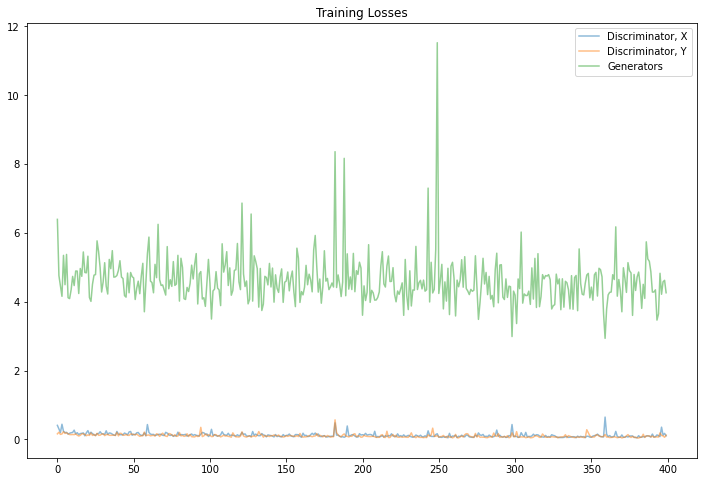

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [31]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


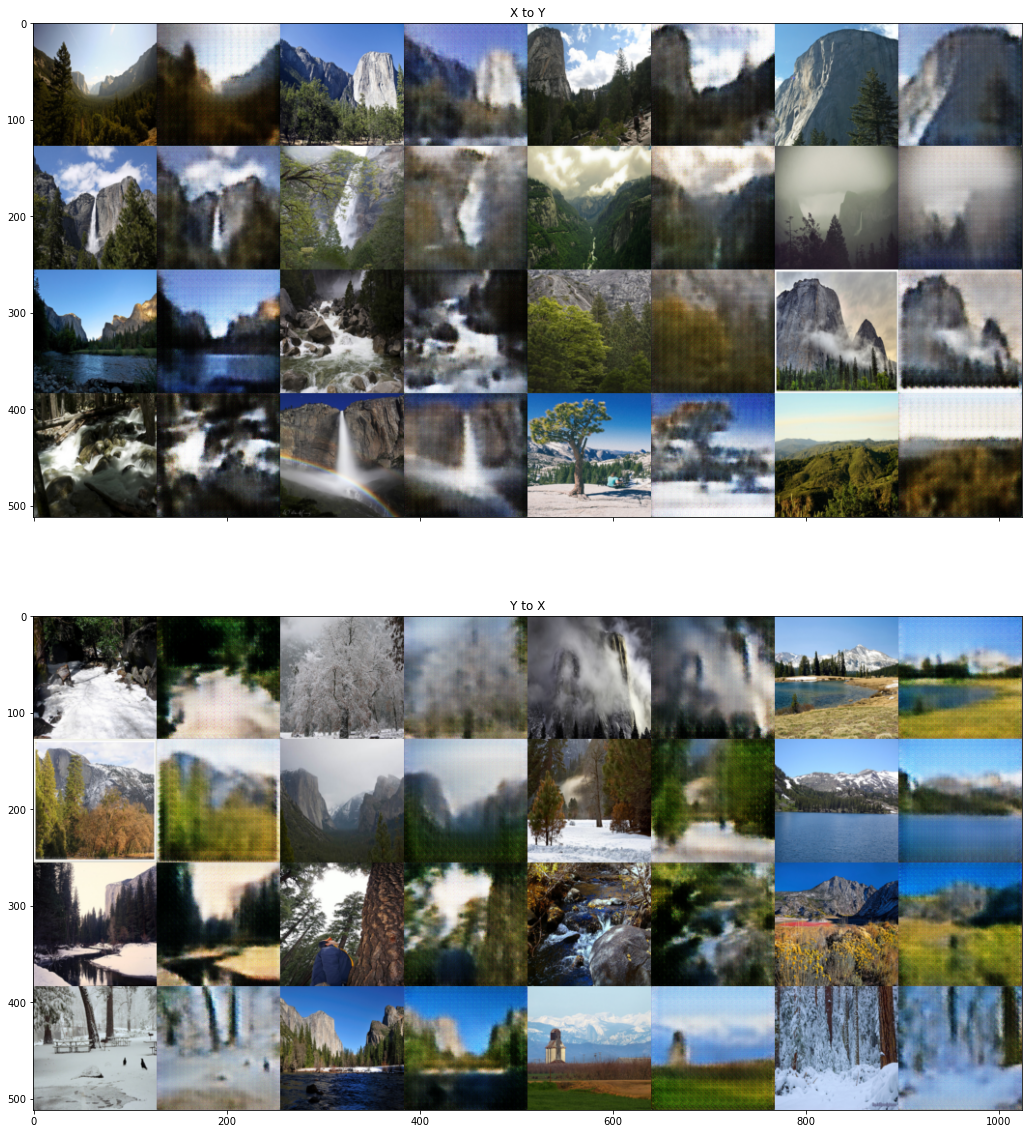

In [32]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

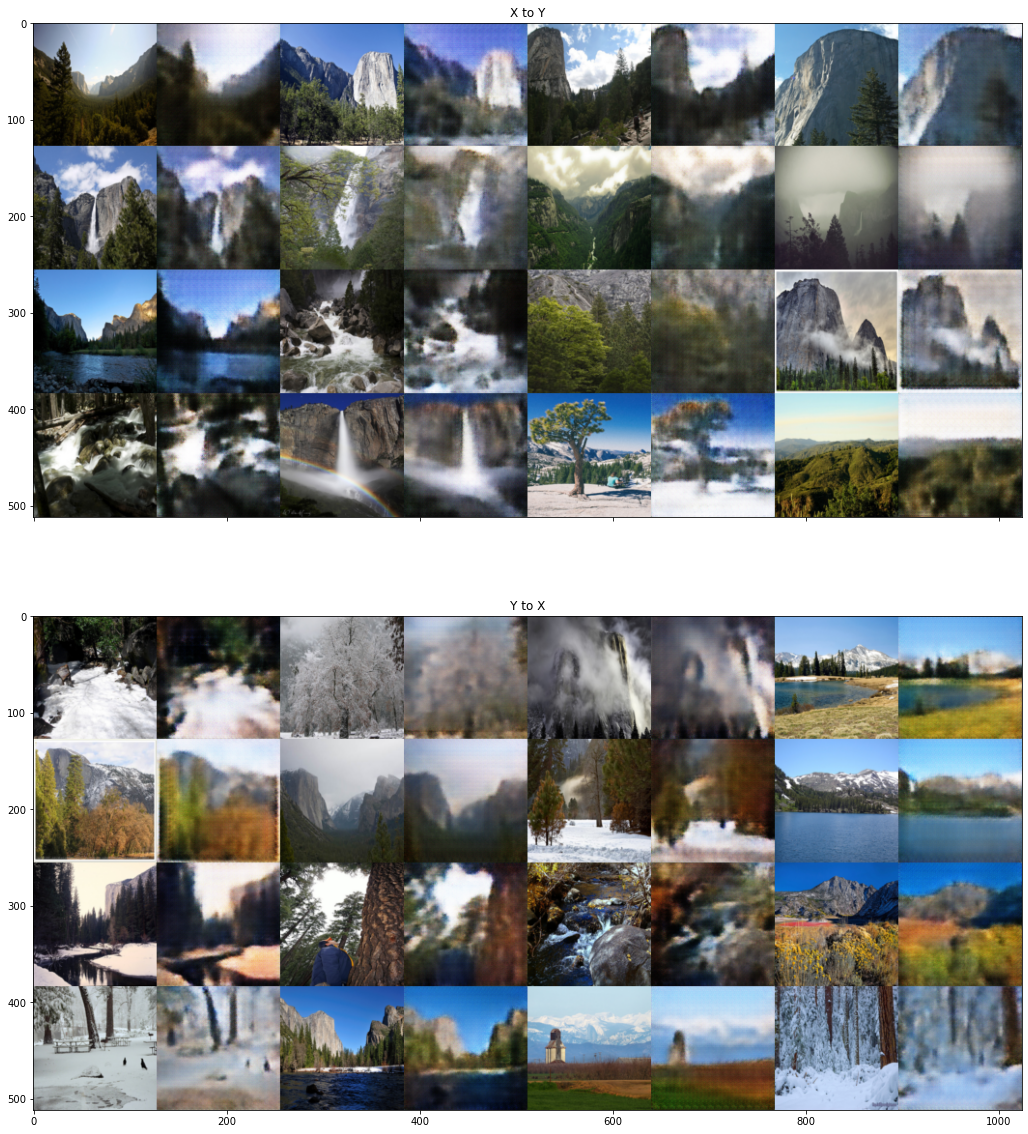

In [33]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.